In [7]:
# standard python utilities
import os
from os.path import join, basename,dirname
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import seaborn as sns

# standard geospatial python utilities
# import pyproj # for converting proj4string
import shapely
import geopandas as gpd

from osgeo import gdal # need to load before rasterio because of issue

import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy

In [5]:
git_dir = os.getcwd()
while basename(git_dir) != 'GitHub':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'
fig_dir = proj_dir+'/Streambed_seepage/figures/'



In [13]:
hob_dir = join(gwfm_dir, 'HOB_data')
dem_dir = gwfm_dir+ '/DEM_data'

In [8]:
loadpth =  'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage'

model_nam = 'inset_oneto_denier'
model_ws = join(loadpth,model_nam)

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [94]:
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_nam,'rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs='epsg:32610')

In [97]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

In [11]:
map_dir = gwfm_dir+'/Mapping/'
df = pd.read_csv(join(hob_dir,'CosumnesRiverPreserve_MW_screened_interval.csv'))
rm_sp = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp = rm_sp.rename(columns={'Well ID':'Sensor'})

# prepare output for modelgrid join
rm_t = rm_sp[rm_sp['At Oneto-Denier']=='Yes']


# find HOB well grid cell
rm_grid = gpd.sjoin(rm_t, grid_p)

# get model layer for heads
hob_row = rm_grid.row.values-1
hob_col = rm_grid.column.values-1

In [14]:
point = list(zip(rm_t.geometry.x.values,rm_t.geometry.y.values))

raster_name = dem_dir+'/mwt_peri_2_3.tif/mwt_peri_2_3_clipped.tif'
with rasterio.open(raster_name) as src:
    rm_t['z_OD_m'] = [sample[0] for sample in src.sample(point)]

raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/modeldomain_10m_transformed.tif"
with rasterio.open(raster_name) as src:
    rm_t['z_USGS_m'] = [sample[0] for sample in src.sample(point)]


C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot: xlabel='Sensor'>

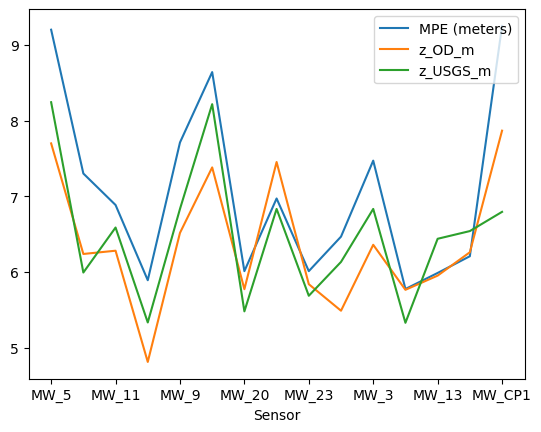

In [23]:
pd.DataFrame(rm_t).plot(x='Sensor', y=['MPE (meters)', 'z_OD_m','z_USGS_m'])
# rm_t

## Zonal stats on 2m DEM

In [27]:
from rasterstats import zonal_stats

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\io.py:17: DeprecationWarning: ReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import ReadingError


In [30]:
fn = proj_dir+'/local_grid_elevation_m_statistics.shp'
if exists(fn):
    zs_df = gpd.read_file(fn)
    zs_df[['row','column']]-=1
else:
    raster_name = dem_dir+'/mwt_peri_2_3.tif/mwt_peri_2_3_clipped.tif'
    dem = rasterio.open(raster_name)
    # affine = dem.affine # didn't work
    affine = dem.meta['transform']

    stats = ['mean', 'median', 'majority','std','min','max']

    # takes several minutes
    zs_grid = zonal_stats(grid_p, raster=raster_name, stats=stats)
    # convert to dataframe
    zs_df = pd.DataFrame(zs_grid)
    # join zone stats of DEM to parcel data
    zs_df = grid_p.join(zs_df)
    # save to shapefile
    zs_df.to_file(proj_dir+'/local_grid_elevation_m_statistics.shp')
    zs_df[['row','column']]-=1

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\rasterstats\main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  i

In [91]:
# zs_df.plot('mean',legend=True)


In [42]:
dem_local = np.zeros((m.dis.nrow,m.dis.ncol))
dem_local[zs_df.row-1, zs_df.column-1] = zs_df['mean']

In [51]:
vmin = np.nanmin((dem_local, m.dis.top.array))
vmax = np.nanmax((dem_local, m.dis.top.array))

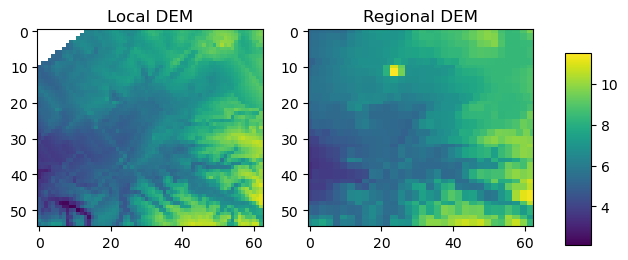

In [59]:

fig,ax=plt.subplots(1,2)
ax[0].imshow(dem_local, vmin=vmin,vmax=vmax)
ax[0].set_title('Local DEM')
ax[1].set_title('Regional DEM')
im = ax[1].imshow(m.dis.top.array, vmin=vmin,vmax=vmax)
cbar_ax = fig.add_axes([0.95, 0.25, 0.04, 0.4])
fig.colorbar(im, cax=cbar_ax)

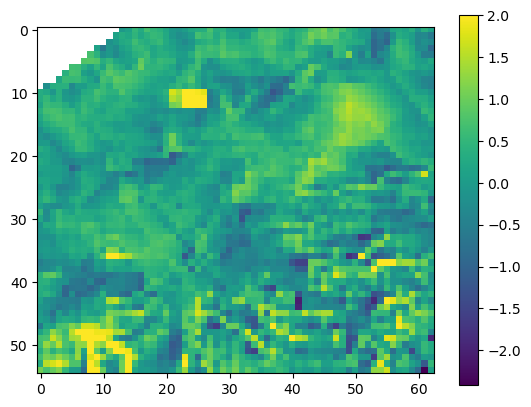

In [68]:
plt.imshow(m.dis.top.array - dem_local, vmax=2)
plt.colorbar()

The local DEM has very similar trends and magnitude to the regional DEM yet with better channel and drainage definition which explains why the channel appears so much lower for the local DEM.

In [96]:
grid_sfr

,node,geometry,node,k,i,j,iseg,ireach,rchlen,strtop,...,strhc1,thts,thti,eps,uhc,reachID,outreach,mean,percentile,percenti10
0,1449,"POLYGON ((642642.031 4243151.603, 642702.352 4...",1448,0,22,62,1,1,100.0,1.726708,...,2.217571,0.0,0.0,0.0,0.0,1,2,10.340412,9.819179,10.928658
1,1511,"POLYGON ((642661.469 4243011.523, 642721.790 4...",1510,0,23,61,2,1,100.0,1.716708,...,0.000000,0.0,0.0,0.0,0.0,2,3,11.124241,10.756749,11.337172
2,1510,"POLYGON ((642601.148 4242931.765, 642661.469 4...",1509,0,23,60,3,1,100.0,1.706708,...,129.600006,0.0,0.0,0.0,0.0,3,4,10.732587,10.407659,11.137097
3,1509,"POLYGON ((642540.827 4242852.007, 642601.148 4...",1508,0,23,59,4,1,100.0,1.696708,...,129.600006,0.0,0.0,0.0,0.0,4,5,10.462025,10.228268,10.717811
4,1508,"POLYGON ((642480.506 4242772.248, 642540.827 4...",1507,0,23,58,5,1,100.0,1.686707,...,129.600006,0.0,0.0,0.0,0.0,5,6,10.139879,9.932000,10.440404
5,1507,"POLYGON ((642420.186 4242692.490, 642480.506 4...",1506,0,23,57,6,1,100.0,1.676708,...,129.600006,0.0,0.0,0.0,0.0,6,7,9.902018,9.732000,10.032001
6,1506,"POLYGON ((642359.865 4242612.731, 642420.186 4...",1505,0,23,56,7,1,100.0,1.666792,...,1.944534,0.0,0.0,0.0,0.0,7,8,9.745774,9.616335,9.904365
7,1505,"POLYGON ((642299.544 4242532.973, 642359.865 4...",1504,0,23,55,8,1,100.0,1.649565,...,1.944534,0.0,0.0,0.0,0.0,8,9,9.670611,9.515488,9.740012
8,1504,"POLYGON ((642239.223 4242453.215, 642299.544 4...",1503,0,23,54,9,1,100.0,1.630585,...,0.896230,0.0,0.0,0.0,0.0,9,10,9.785573,9.631053,10.141650
9,1567,"POLYGON ((642318.982 4242392.894, 642379.302 4...",1566,0,24,54,10,1,100.0,1.609239,...,0.896230,0.0,0.0,0.0,0.0,10,11,9.888033,9.726357,10.143607


In [98]:
dem_stat = gpd.read_file(join(gwfm_dir,'DIS_data/grid_elevation_m_statistics.shp'))
dem_stat[['row','column']]-=1

grid_reg = grid_sfr.join(dem_stat.set_index(['row','column'])[['mean','percentile','percenti10']], on=['i','j'])
grid_loc = grid_sfr.join(zs_df.set_index(['row','column'])[['mean','min','max']], on=['i','j'])


<AxesSubplot: >

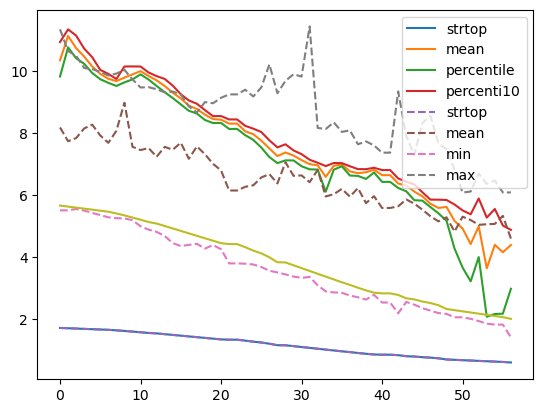

In [112]:
fig,ax=plt.subplots()
grid_reg.plot(y=['strtop','mean','percentile','percenti10'],kind='line', ax=ax)
grid_loc.plot(y=['strtop','mean','min','max'],kind='line',style='--',ax=ax)

(grid_sfr.strtop/0.3048).plot(ax=ax)

Plotting the zonal stats on the local scale shows that the elevation minimums for all sfr grid cells are much higher than what was predicted by the cross-section sampling which means that the cross-section might be accidentally pulling lower points at further distances. I multiplied the minimums sampled by 3.28084 and found that I hadn't removed the conversion from ft to meters in the XS sampling code which is what is causing the error.

In [71]:
fp_logger = pd.read_csv(join(gwfm_dir,'LAK_data','floodplain_logger_metadata.csv'))
fp_logger = gpd.GeoDataFrame(fp_logger, geometry = gpd.points_from_xy(fp_logger.Easting, fp_logger.Northing), crs='epsg:32610')
# find grid cell it is within
fp_grid = gpd.sjoin(fp_logger, grid_p, how='left',predicate='within')

In [76]:
fp_grid['local_dem'] = dem_local[fp_grid.row-1,fp_grid.column-1]
fp_grid['regional_dem'] = m.dis.top.array[fp_grid.row-1,fp_grid.column-1]

Plotting the mean elevation from the local versus the preset elevations of the floodplain loggers shows that it is actually higher than expected. So the 2m DEM isn't actually too low in terms of height. The issue for the strm top may lie in how the raster is sampled and the minimum is chosen.

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(-1.0, 0, 'LOGGER_D'),
  Text(0.0, 0, 'LWC'),
  Text(1.0, 0, 'TwinCities_West'),
  Text(2.0, 0, 'LOGGER_A'),
  Text(3.0, 0, 'LOGGER_B'),
  Text(4.0, 0, 'LOGGER_C'),
  Text(5.0, 0, 'LOGGER_D'),
  Text(6.0, 0, '')])

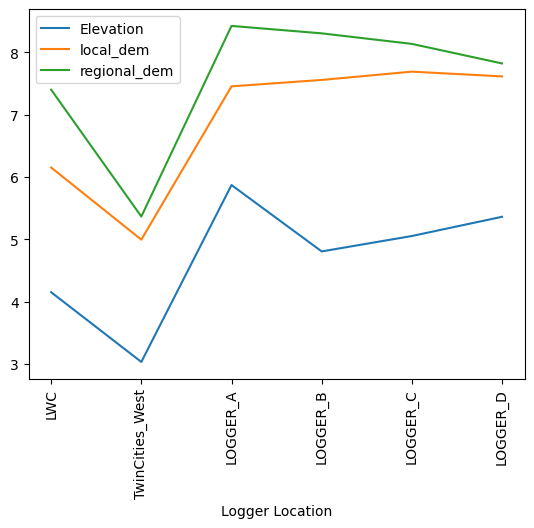

In [89]:
fp_grid[fp_grid['Logger Type']=='River'].plot(x = 'Logger Location', y=['Elevation','local_dem','regional_dem'],kind='line')
plt.xticks(rotation=90)